I have wrapped the functions into 'devendo' script to facilitate convenient analysis. The environment requirement can be found in env directory.

In [1]:
import sys,warnings
sys.path.append('/share/home/lhlin/workspace/1-EndoAtlas/Reproduce/DevEndo/') # change to the path where devendo.py stript located.
import devendo as de
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import anndata, re,os
from scipy.sparse import csr_matrix,csc_matrix, find
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
sc.settings.set_figure_params(dpi=100, facecolor='white')
pd.set_option("display.max_rows", 40)
pd.set_option("display.precision", 2)

## 1. Load STED-EC dataset

The expression matrix can be download from [figshare](https://figshare.com/account/items/30689990/edit). The lognormal matrix is stored in adata.X, and the raw count matrix is stored in adata.raw.X. The adata.obs['label'] present the cell type label, and the adata.obs['organ'] present the organ label.

In [2]:
adata = sc.read_h5ad('../DATA/sted-ec.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 70915 × 55450
    obs: 'CellID_Library', 'new_cellid_unique', 'doublet_score', 'embryonic_period', 'day', 'gender', 'mouse_part_summary', 'library_time', 'sample', 'n_counts', 'n_genes', 'percent_mito', 'predict_doublet', 'Gja5+_label', 'organ', 'label'
    var: 'Ensembl_id'
    uns: 'Gja5+_label_colors', 'clusters_colors', 'clustes_colors', 'day_colors', 'embryonic_period_colors', 'hvg', 'label_2024_colors', 'label_colors', 'label_endoMT_colors', 'label_endo_colors', 'leiden', 'leiden_colors', 'mouse_part_summary_colors', 'neighbors', 'organ_colors', 'predict_label_colors', 'predict_proba', 'subtype_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

## 2. Overview of the dataset

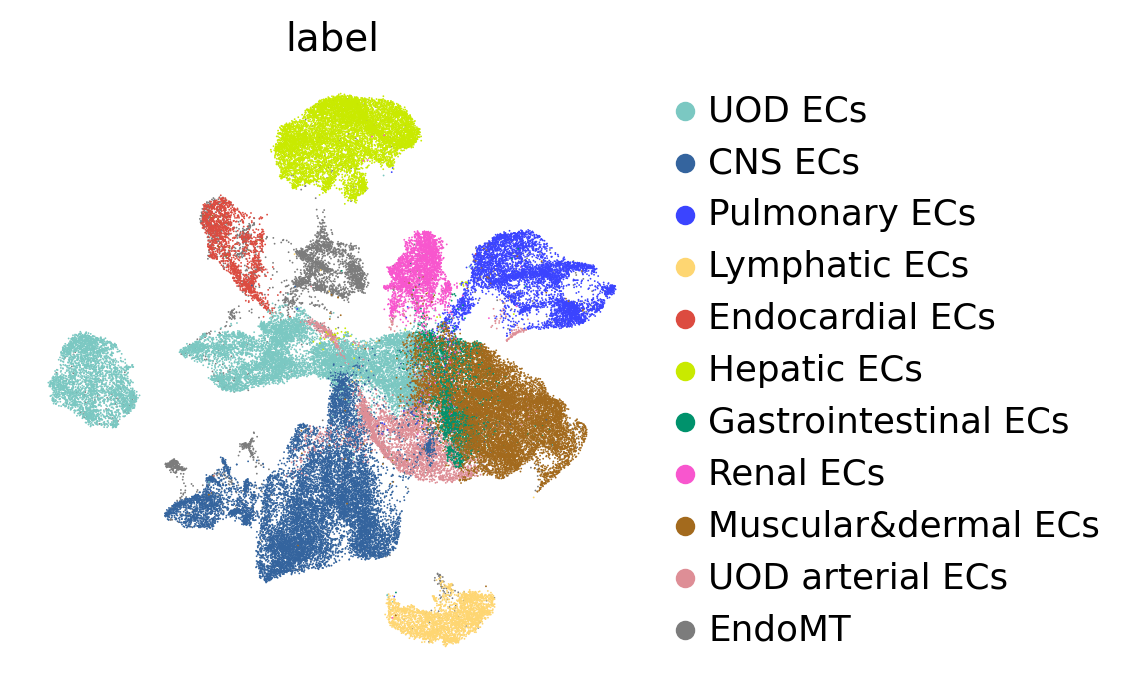

In [4]:
sc.pl.umap(adata, color = ['label'], frameon=False)

## 3. Cell type markers

### 3.1 Find differentially expresssed genes

In [25]:
deg = de.FindAllMarkers(adata, 'label')

Calculate DEGs...


In [26]:
deg

names    group scores      pvals  pvals_adj logfoldchanges pct_1  \
0         Bex1  UOD ECs  23.81  2.87e-125  1.36e-122           3.38  0.78   
1         Prtg  UOD ECs  21.69  2.54e-104  7.38e-102           3.81  0.66   
2       Trim71  UOD ECs  21.51  1.21e-102  3.35e-100           3.54  0.66   
3         Bex2  UOD ECs  21.08   1.33e-98   3.28e-96           2.82  0.71   
4        Hmga2  UOD ECs  24.71  8.44e-135   5.2e-132           2.63  0.89   
...        ...      ...    ...        ...        ...            ...   ...   
1393     Basp1   EndoMT  10.87   1.62e-27   1.01e-24           1.06  0.77   
1394      Akt2   EndoMT   8.28   1.19e-16   2.68e-14           1.14  0.45   
1395  Ppp1r14a   EndoMT   8.33   7.88e-17   1.83e-14           1.58  0.41   
1396    Cited2   EndoMT   8.28   1.27e-16   2.84e-14           0.83  0.59   
1397     Plod2   EndoMT   8.39   4.94e-17   1.17e-14           1.05  0.52   

     pct_2 diff_pct group_mean group_cv  
0     0.21     0.57       0.93     0.85  
1     0.09     0.57       0.55     1.00  
2     0.09     0.56       0.43     0.94  
3     0.17     0.53       0.62     0.86  
4     0.36     0.53       1.22     0.60  
...    ...      ...        ...      ...  
1393  0.56     0.21       0.94     0.80  
1394  0.24     0.21       0.20     1.39  
1395  0.20     0.21       0.28     1.62  
1396  0.39     0.21       0.44     1.16  
1397  0.32     0.20       0.29     1.29  

[1398 rows x 11 columns]

### 3.2 Heatmap

In [36]:
top_deg = deg.sort_values(by='logfoldchanges',ascending=False).groupby('group').head(8)
marker_dict = de.split(top5_deg['names'],top5_deg['group'])
marker_dict = {i:marker_dict[i] for i in adata.obs['label'].cat.categories}

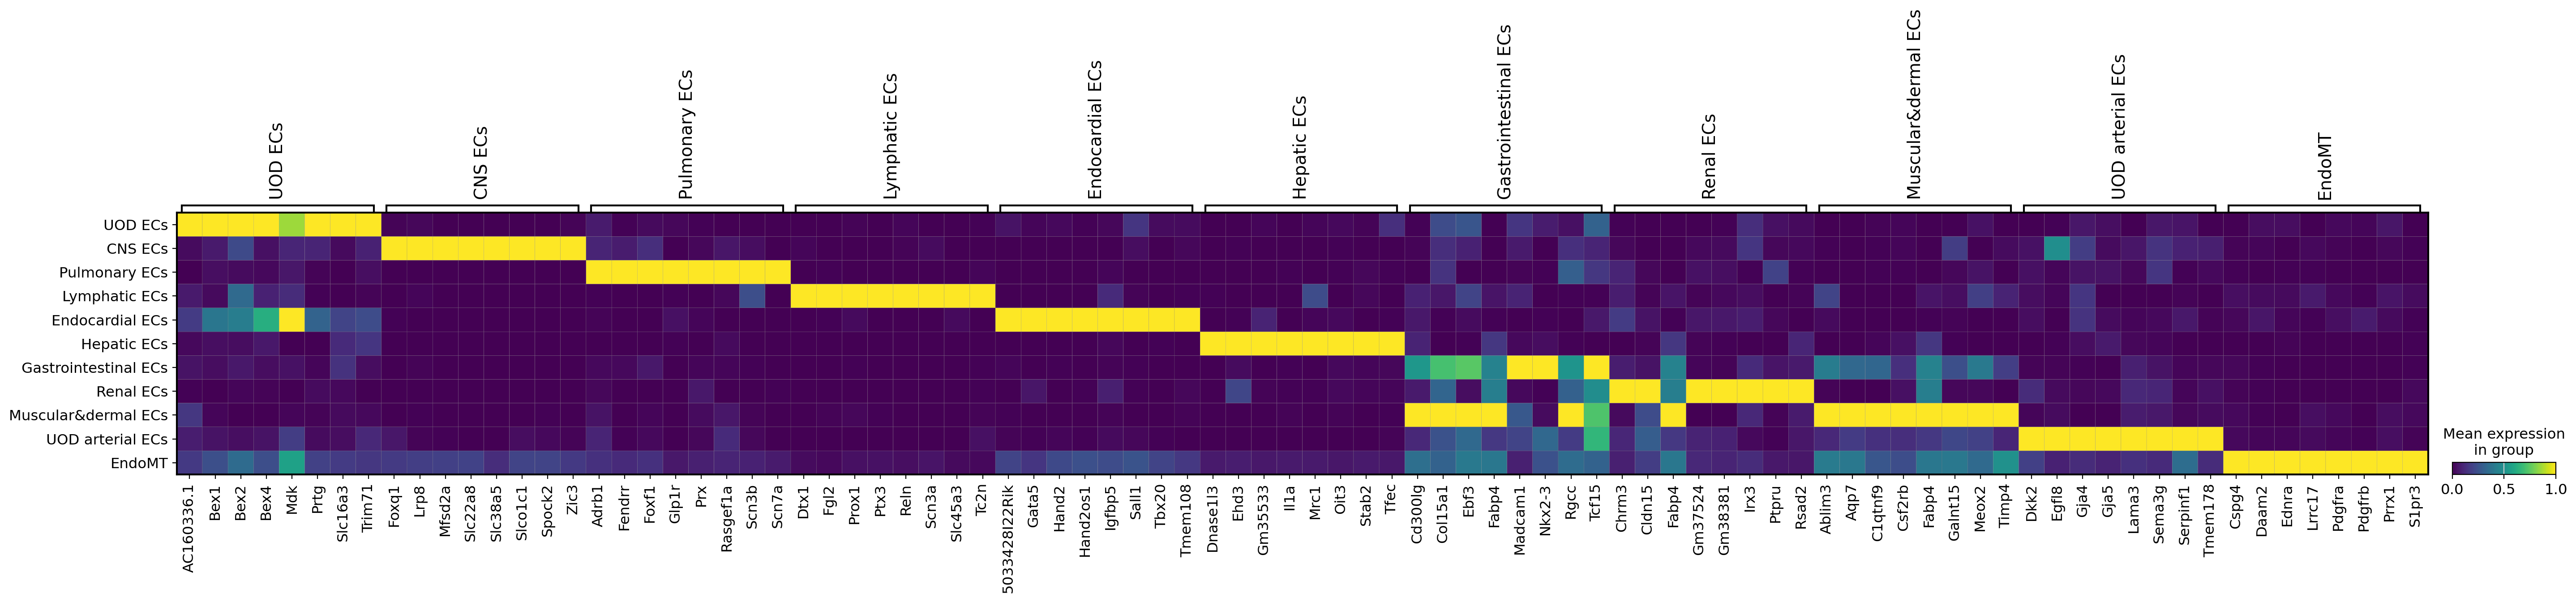

In [37]:
sc.pl.matrixplot(adata, marker_dict, standard_scale='var',groupby="label",swap_axes=False,  cmap="viridis")

### 3.3 Violin plots

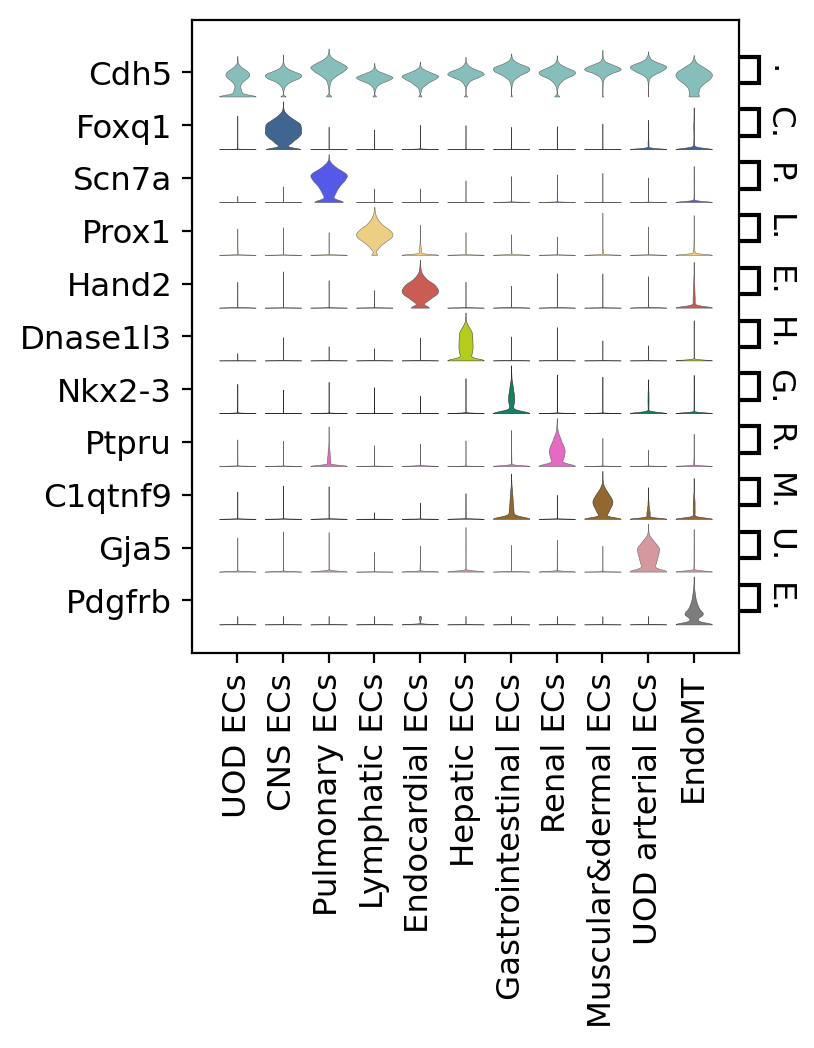

In [6]:
new_marker_dict = {
    'UOD ECs':['Cdh5'],
    'CNS ECs':['Foxq1'],
    'Pulmonary ECs':['Scn7a'],
    'Lymphatic ECs':['Prox1'],
    'Endocardial ECs':['Hand2'],
    'Hepatic ECs':['Dnase1l3'],
    'Gastrointestina ECs':['Nkx2-3'],
    'Renal ECs':['Ptpru'],
    'Muscular&dermal ECs':['C1qtnf9'],
    'UODArterial ECs':['Gja5'],
    'EndoMT':['Pdgfrb']
}
sc.pl.stacked_violin(adata,
                     new_marker_dict,size=1, groupby='label',swap_axes =True,use_raw=False,
                     order = adata.obs['label'].cat.categories.tolist(),
                     row_palette = ['#7BC8C2', '#34649E', '#3B44FF', '#FED672', '#DC4B40', '#C9EA00','#00926C', '#F856CE', '#A36A1D', '#DE8E96', '#7c7c7c'],
                     standard_scale='var');

### 3.4 UMAP plots

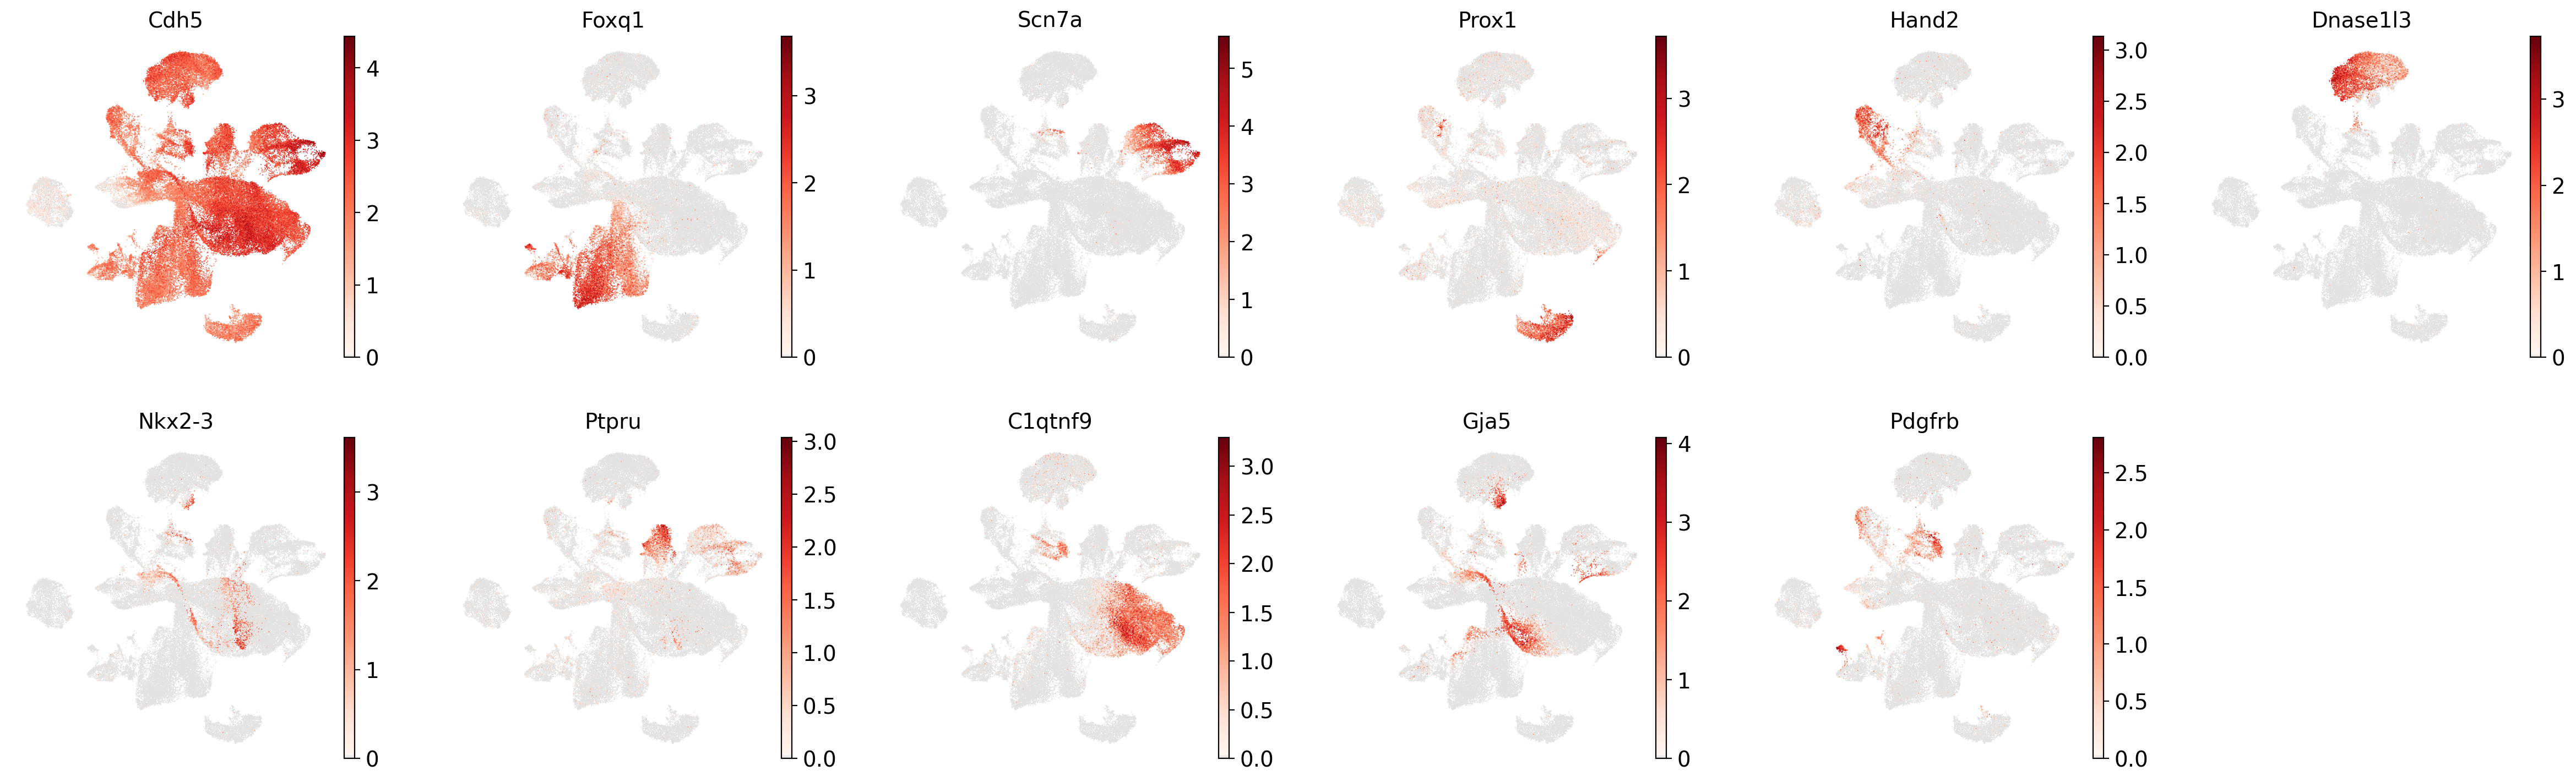

In [46]:
sc.pl.umap(adata, use_raw = False, color = np.concatenate([new_marker_dict[i] for i in new_marker_dict]), cmap = de.mymap, frameon=False,ncols=6)

### 3.5 Gene expression over time

In [47]:
marker_dict = {
    'UOD ECs':['Phlda2','Fgf3'],
    'CNS ECs':['Foxq1','Pglyrp1'],
    'Pulmonary ECs':['Foxf1','Scn7a'],
    'Lymphatic ECs':['Reln','Prox1'],
    'Endocardial ECs':['Hand2','Tmem108'],
    'Hepatic ECs':['Lyve1','Dnase1l3'],
    'Gastrointestinal ECs':['Cd36','Nkx2-3'],
    'Renal ECs':['Pbx1','Ptpru'],
    'Muscular&dermal ECs':['Meox2','C1qtnf9'],
    'UOD arterial ECs':['Serpinf1','Gja5'],
}
used_celltype = ['UOD ECs','CNS ECs','Pulmonary ECs','Lymphatic ECs',
                 'Endocardial ECs','Hepatic ECs','Gastrointestinal ECs',
                 'Renal ECs','Muscular&dermal ECs','UOD arterial ECs']

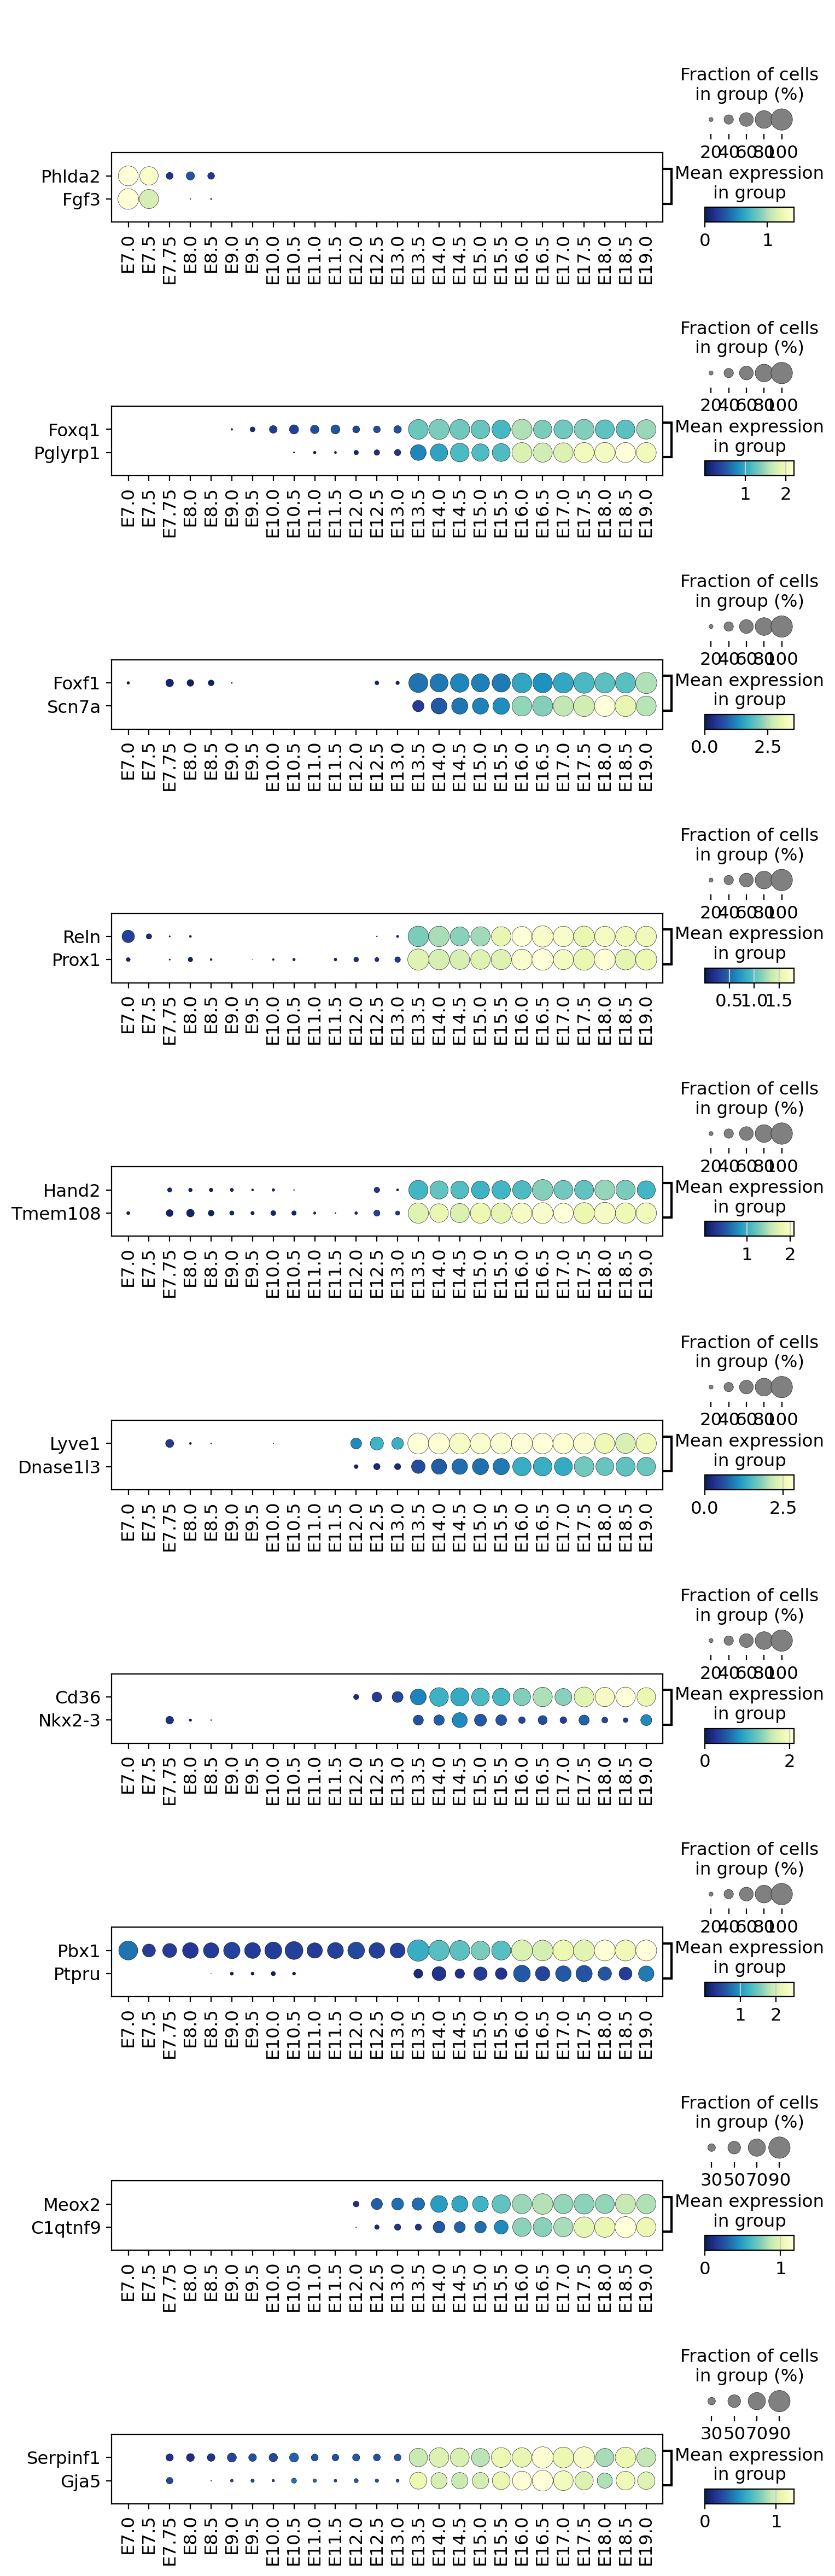

In [62]:
f, axs = plt.subplots(len(used_celltype),1,sharex=True,figsize=(8,30))
for ct in used_celltype:
    all_tp = pd.Series(['E7.0', 'E7.5', 'E7.75', 'E8.0', 'E8.5', 'E9.0', 'E9.5', 'E10.0',
       'E10.5', 'E11.0', 'E11.5', 'E12.0', 'E12.5', 'E13.0', 'E13.5', 'E14.0',
       'E14.5', 'E15.0', 'E15.5', 'E16.0', 'E16.5', 'E17.0', 'E17.5', 'E18.0',
       'E18.5', 'E19.0'])
    current_tp = adata[adata.obs['label'].isin(['UOD ECs',ct])].obs['embryonic_period'].cat.categories
    addition_tp = all_tp[~all_tp.isin(current_tp)].values
    
    sc.pl.dotplot(adata[adata.obs['label'].isin(['UOD ECs',ct])|adata.obs['embryonic_period'].isin(addition_tp)],
                  {'':marker_dict[ct]}, 'embryonic_period', 
              cmap = 'YlGnBu_r',dot_min =0.1, use_raw=False,
              swap_axes = True, smallest_dot = False,
              dendrogram=False,# dot_max = 1 ,
              ax = axs[used_celltype.index(ct)],
              show=False)